# Assignment 5

Deadline: 11.06.2025 12:00 CEST

Panagiotis Patsias, 23-720-394, panagiotis.patsias@uzh.ch

Liam Kane, 19-734-862, liam.kane@uzh.ch

Tim Vorburger, 20-703-302, tim.vorburger@uzh.ch

Christopher Narayanan, 21-730-916, christopher.narayanan@uzh.ch

## Task

Develop an investment strategy for the Swiss equity market, backtest it using the provided datasets (`market_data.parquet`, `jkp_data.parquet`, `spi_index.csv`) and analyze its performance by benchmarking it against the SPI index. Work with the existing code infrastructure (`qpmwp-course`) and extend it by implementing any additional components needed for the strategy. Write a report that presents your methodology and the results.

### Coding (15 points)

- Selection:
  Implement selection item builder functions (via `SelectionItemBuilder`) to filter stocks based on specific criteria (e.g., exclude low-quality or high-volatility stocks).

- Optimization Data & Constraints:
  Implement functions to prepare optimization data (via `OptimizationItemBuilder`), including any econometric or machine learning-based predictions. These functions should also define optimization constraints (e.g., stock, sector, or factor exposure limits).

- Optimization Model:
  If you choose to create a custom optimization model, develop a class inheriting from Optimization (similar to `MeanVariance`, `LeastSquares`, or `BlackLitterman`). Your class should include methods set_objective and solve for defining the objective function and solving the optimization problem.

- Machine Learning Prediction:
  Integrate a machine learning model to estimate inputs for the optimization, such as expected returns or risk. This could include regression, classification, or learning-to-rank models. I suggest you to use the provided jkp_data as features, but you may also create your own (e.g., technical indicators computed on the return or price series).

- Simulation:
  Backtest the strategy and simulate portfolio returns. Account for fixed costs (1% per annum) and variable (transaction) costs (0.2% per rebalancing).


### Report (15 points):

Generate an HTML report with the following sections:

- High-level strategy overview: Describe the investment strategy you developed.

- Detailed explanation of the backtesting steps: Offer a more comprehensive breakdown of the backtesting process, including a description of the models implemented (e.g., details of the machine learning method used).

- Backtesting results:
    
    - Charts: Include visual representations (e.g., cumulative performance charts, rolling 3-year returns, etc.).
    - Descriptive statistics: Present key statistics such as mean, standard deviation, drawdown, turnover, and Sharpe ratio (or any other relevant metric) for the full backtest period as well as for subperiods (e.g., the last 5 years, or during bull vs. bear market phases).
    - Compare your strategy against the SPI index.


# Imports

In [1]:
import numpy as np
import pandas as pd
import os
import sys
import copy
from typing import Optional
project_root = os.path.dirname(os.path.dirname(os.getcwd()))   
src_path = os.path.join(project_root, 'qpmwp-course/src')    
sys.path.append(project_root)
sys.path.append(src_path)
from backtesting.backtest_item_builder_classes import (
    SelectionItemBuilder,
    OptimizationItemBuilder,
)
from backtesting.backtest_item_builder_functions import (
    bibfn_selection_min_volume,
    bibfn_selection_gaps,
    bibfn_return_series,
    bibfn_budget_constraint,
    bibfn_box_constraints,
    bibfn_size_dependent_upper_bounds,
    bibfn_selection_min_mktcap,
    bibfn_selection_volatility,
    bibfn_selection_NA,
    bibfn_expected_returns,
    bibfn_cap_weights,
    bibfn_scores,
    bibfn_selection_jkp_factor_scores,
    bibfn_turnover_constraint,
    bibfn_factor_exposure_constraint,
    bibfn_sector_exposure_constraint,
    bibfn_selection_gaps,
    bibfn_bm_series,
    bibfn_selection_ltr,
    bibfn_scores_ltr
    

                               
    
    
)
from backtesting.backtest_data import BacktestData
from backtesting.backtest_service import BacktestService
from backtesting.backtest import Backtest


In [2]:
import pandas as pd

df_market = pd.read_parquet("/home/patsias/QPM/qpmwp-course/data/market_data.parquet")
df2_jkp = pd.read_parquet("/home/patsias/QPM/qpmwp-course/data/jkp_data.parquet")

In [3]:
df_market

,,price,mktcap,liquidity,sector
date,id,,,,
1999-05-06,1,461.000000,1.235952e+09,129080.0,None
1999-05-07,1,455.000000,1.219866e+09,4550.0,None
1999-05-10,1,455.000000,1.219866e+09,910.0,None
1999-05-11,1,460.000000,1.233271e+09,4600.0,None
1999-05-12,1,460.000000,1.233271e+09,460.0,None
...,...,...,...,...,...
2024-04-24,313,9.814924,2.016783e+07,0.0,None
2024-04-25,313,9.814924,2.016783e+07,0.0,None
2024-04-26,313,9.814924,2.016783e+07,0.0,None


# Sector processing

In [4]:
df_market = df_market.reset_index()
has_sector = df_market.groupby('id')['sector'].apply(lambda x: x.notna().any())
print("Total unique IDs:", has_sector.shape[0])
print("IDs with sector info:", has_sector.sum())
print("IDs missing all sector info:", (~has_sector).sum())


Total unique IDs: 313
IDs with sector info: 275
IDs missing all sector info: 38


In [5]:
id_to_sector = df_market.dropna(subset=['sector']).drop_duplicates(subset='id', keep='first').set_index('id')['sector']
df_market['sector'] = df_market['id'].map(id_to_sector)
df_market_filled = df_market.set_index(['date', 'id'])

In [6]:
valid_ids = (
    df_market.groupby('id')['sector']
    .apply(lambda x: x.notna().any())
)
valid_ids = valid_ids[valid_ids].index 
df_market = df_market[df_market['id'].isin(valid_ids)]


In [7]:
df_market

,date,id,price,mktcap,liquidity,sector
0,1999-05-06,1,461.000000,1.235952e+09,129080.0,40
1,1999-05-07,1,455.000000,1.219866e+09,4550.0,40
2,1999-05-10,1,455.000000,1.219866e+09,910.0,40
3,1999-05-11,1,460.000000,1.233271e+09,4600.0,40
4,1999-05-12,1,460.000000,1.233271e+09,460.0,40
...,...,...,...,...,...,...
1434077,2024-04-24,313,9.814924,2.016783e+07,0.0,60
1434078,2024-04-25,313,9.814924,2.016783e+07,0.0,60
1434079,2024-04-26,313,9.814924,2.016783e+07,0.0,60
1434080,2024-04-29,313,10.905471,2.240870e+07,2000.0,60


In [8]:
GICS_SECTOR_MAP = {
    '10': 'Energy',
    '15': 'Materials',
    '20': 'Industrials',
    '25': 'Consumer Discretionary',
    '30': 'Consumer Staples',
    '35': 'Health Care',
    '40': 'Financials',
    '45': 'Information Technology',
    '50': 'Communication Services',
    '55': 'Utilities',
    '60': 'Real Estate'
}


In [9]:
df_market['sector'] = df_market['sector'].astype(str).map(GICS_SECTOR_MAP)


In [10]:
df_market['sector'].unique()

array(['Financials', 'Consumer Staples', 'Real Estate', 'Health Care',
       'Energy', 'Industrials', 'Utilities', 'Materials',
       'Consumer Discretionary', 'Information Technology',
       'Communication Services'], dtype=object)

In [11]:
df_market = df_market.set_index(['date', 'id'])

In [12]:
df2_jkp

niq_su  ret_6_1  ret_12_1  saleq_su  tax_gr1a  ni_inc8q  \
date       id                                                             
1985-12-31 7       NaN      NaN       NaN       NaN       NaN       NaN   
           7       NaN      NaN       NaN       NaN       NaN       NaN   
           7       NaN      NaN       NaN       NaN       NaN       NaN   
           9       NaN      NaN       NaN       NaN       NaN       NaN   
           11      NaN      NaN       NaN       NaN       NaN       NaN   
...                ...      ...       ...       ...       ...       ...   
2024-03-31 NaN     NaN      NaN       NaN       NaN       NaN       NaN   
           NaN     NaN      NaN       NaN       NaN       NaN       NaN   
           NaN     NaN      NaN       NaN       NaN       NaN       NaN   
           NaN     NaN      NaN       NaN       NaN       NaN       NaN   
           NaN     NaN      NaN       NaN       NaN       NaN       NaN   

                prc_highprc_252d  resff3_6_1  resff3_12_1  be_me  ...  \
date       id                                                     ...   
1985-12-31 7                 NaN         NaN          NaN    NaN  ...   
           7                 NaN         NaN          NaN    NaN  ...   
           7                 NaN         NaN          NaN    NaN  ...   
           9                 NaN         NaN          NaN    NaN  ...   
           11                NaN         NaN          NaN    NaN  ...   
...                          ...         ...          ...    ...  ...   
2024-03-31 NaN               NaN         NaN          NaN    NaN  ...   
           NaN               NaN         NaN          NaN    NaN  ...   
           NaN               NaN         NaN          NaN    NaN  ...   
           NaN               NaN         NaN          NaN    NaN  ...   
           NaN               NaN         NaN          NaN    NaN  ...   

                rmax5_rvol_21d  ni_be  ocf_at  ocf_at_chg1  mispricing_perf  \
date       id                                                                 
1985-12-31 7               NaN    NaN     NaN          NaN              NaN   
           7               NaN    NaN     NaN          NaN              NaN   
           7               NaN    NaN     NaN          NaN              NaN   
           9               NaN    NaN     NaN          NaN              NaN   
           11              NaN    NaN     NaN          NaN              NaN   
...                        ...    ...     ...          ...              ...   
2024-03-31 NaN             NaN    NaN     NaN          NaN              NaN   
           NaN             NaN    NaN     NaN          NaN              NaN   
           NaN             NaN    NaN     NaN          NaN              NaN   
           NaN             NaN    NaN     NaN          NaN              NaN   
           NaN             NaN    NaN     NaN          NaN              NaN   

                mispricing_mgmt  qmj  qmj_prof  qmj_growth  qmj_safety  
date       id                                                           
1985-12-31 7                NaN  NaN       NaN         NaN         NaN  
           7                NaN  NaN       NaN         NaN         NaN  
           7                NaN  NaN       NaN         NaN         NaN  
           9                NaN  NaN       NaN         NaN         NaN  
           11               NaN  NaN       NaN         NaN         NaN  
...                         ...  ...       ...         ...         ...  
2024-03-31 NaN              NaN  NaN       NaN         NaN         NaN  
           NaN              NaN  NaN       NaN         NaN         NaN  
           NaN              NaN  NaN       NaN         NaN         NaN  
           NaN              NaN  NaN       NaN         NaN         NaN  
           NaN              NaN  NaN       NaN         NaN         NaN  

[130578 rows x 153 columns]

# Rank processing

In [13]:
from helper_functions import load_data_spi, load_pickle
data = BacktestData()
data.market_data = df_market
data.jkp_data = df2_jkp
data.bm_series = load_data_spi(path='../data/')
market_data_dates = data.market_data.index.get_level_values('date').unique().sort_values()
jkp_data_dates = data.jkp_data.index.get_level_values('date').unique().sort_values()

# Find the nearest future market_data_date for each jkp_data_date
dates_map = {
    date: min(market_data_dates[market_data_dates > date])
    for date in jkp_data_dates
}

In [14]:

# Generates a features dataframe from the jkp_data where you reset
# the date index to b
features = data.jkp_data.reset_index()
features['date'] = features['date'].map(dates_map)
features = features.set_index(['date', 'id'])

# Define training dates and rebalancing dates

train_dates = features.index.get_level_values('date').unique().sort_values()
train_dates = train_dates[train_dates > market_data_dates[0]]
rebdates = train_dates[train_dates >= '2015-01-01'].strftime('%Y-%m-%d').tolist()
rebdates = rebdates[0:-1]


# Prepare labels (i.e., ranks of period returns)

# Load return series
return_series = data.get_return_series()
return_series_agg = (1 + return_series).cumprod().loc[train_dates].pct_change()
# Shift the labels by -1 period (as we want to predict next period return ranks)
return_series_agg_shift = return_series_agg.shift(-1)  
ret = return_series_agg_shift.unstack().reorder_levels([1, 0]).dropna()
ret.name = 'ret'

merged_df = ret.to_frame().join(features, how='inner').sort_index()

# Generate the labels (ranks) for the merged data
labels = merged_df.groupby('date')['ret'].rank(method='first', ascending=True).astype(int)
labels = 100 * labels / merged_df.groupby('date').size() # Normalize the ranks to be between 0 and 100
labels = labels.astype(int) 
merged_df.insert(0, 'label', labels)
merged_df.reset_index(inplace=True)

data.merged_df = merged_df

/tmp/ipykernel_111511/2166400439.py:19: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  return_series_agg = (1 + return_series).cumprod().loc[train_dates].pct_change()


In [15]:
data.merged_df

,date,id,label,ret,niq_su,ret_6_1,ret_12_1,saleq_su,tax_gr1a,ni_inc8q,...,rmax5_rvol_21d,ni_be,ocf_at,ocf_at_chg1,mispricing_perf,mispricing_mgmt,qmj,qmj_prof,qmj_growth,qmj_safety
0,1986-01-01,48,25,-0.096154,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1986-01-01,48,50,-0.096154,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1986-01-01,48,75,-0.096154,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1986-01-01,48,100,-0.096154,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1986-02-03,119,68,0.009346,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75156,2024-03-01,84,56,0.032710,0.503565,0.067636,0.251101,0.383709,0.001498,7.0,...,NaN,0.292796,0.151569,0.043153,NaN,NaN,NaN,NaN,NaN,NaN
75157,2024-03-01,86,87,0.108974,-0.219542,0.014170,0.031011,-1.992676,-0.007793,0.0,...,NaN,0.232449,0.157985,-0.064977,NaN,NaN,NaN,NaN,NaN,NaN
75158,2024-03-01,88,62,0.042675,-0.656944,0.086802,0.300713,0.984376,-0.005008,8.0,...,NaN,0.125631,0.127815,0.031734,NaN,NaN,NaN,NaN,NaN,NaN
75159,2024-03-01,89,38,0.009346,0.226057,-0.023888,0.032793,1.712224,-0.000303,3.0,...,NaN,0.085045,0.088290,0.001136,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
df_market 

,,price,mktcap,liquidity,sector
date,id,,,,
1999-05-06,1,461.000000,1.235952e+09,129080.0,Financials
1999-05-07,1,455.000000,1.219866e+09,4550.0,Financials
1999-05-10,1,455.000000,1.219866e+09,910.0,Financials
1999-05-11,1,460.000000,1.233271e+09,4600.0,Financials
1999-05-12,1,460.000000,1.233271e+09,460.0,Financials
...,...,...,...,...,...
2024-04-24,313,9.814924,2.016783e+07,0.0,Real Estate
2024-04-25,313,9.814924,2.016783e+07,0.0,Real Estate
2024-04-26,313,9.814924,2.016783e+07,0.0,Real Estate


In [17]:
selection_item_builders = {
    'min_mktcap': SelectionItemBuilder(
        bibfn = bibfn_selection_min_mktcap,
        threshold = 1e8
    ),
    'volatility': SelectionItemBuilder(
        bibfn = bibfn_selection_volatility,
        window = 63,
        max_vol = 0.03, 
    ),
    'min_volume': SelectionItemBuilder(
    bibfn=bibfn_selection_min_volume,
    min_volume=500_000,
    ),

    'gaps': SelectionItemBuilder(
    bibfn=bibfn_selection_gaps,
    width=252,
    n_days=10,  
),
    'ltr': SelectionItemBuilder(
        bibfn = bibfn_selection_ltr,
    ),



}

optimization_item_builders = {
    
    'return_series': OptimizationItemBuilder(
        bibfn=bibfn_return_series,
        width=252*3,
        fill_value=0,
    ),
    'budget_constraint': OptimizationItemBuilder(
        bibfn=bibfn_budget_constraint,
        budget=1,
    ),
    'box_constraints': OptimizationItemBuilder(
        bibfn=bibfn_box_constraints,
        upper=0.1,
    ),
    'size_dep_upper_bounds': OptimizationItemBuilder(
        bibfn=bibfn_size_dependent_upper_bounds,
        small_cap={'threshold': 300_000_000, 'upper': 0.02},
        mid_cap={'threshold': 1_000_000_000, 'upper': 0.05},
        large_cap={'threshold': 10_000_000_000, 'upper': 0.1},
    ),
    'cap_weights': OptimizationItemBuilder(
        bibfn=bibfn_cap_weights,
    ),

    'sector_exposure_constraints': OptimizationItemBuilder(
    bibfn=bibfn_sector_exposure_constraint,
    max_sector_weight={
        'Financials': 0.2,
        'Consumer Staples': 0.2,
        'Real Estate': 0.2,
        'Health Care': 0.2,
        'Energy': 0.2,
        'Industrials': 0.2,
        'Utilities': 0.2,
        'Materials': 0.2,
        'Consumer Discretionary': 0.2,
        'Information Technology': 0.2,
        'Communication Services': 0.2,
    },
),

   'scores_ltr': OptimizationItemBuilder(
        bibfn = bibfn_scores_ltr,
        params_xgb = {
            'objective': 'rank:pairwise',
            'min_child_weight': 1,
            'max_depth': 6,
            'eta': 0.1,
            'gamma': 1.0,
            'lambda': 1,
            'alpha': 0
        },
        training_dates = train_dates,
    ), 

        'turnover_constraint': OptimizationItemBuilder(
            bibfn = bibfn_turnover_constraint,
            turnover_limit = 0.25,
        ),
        
# ------------------------------------------------------------------------------------------------------------------------------
# We initially implemented the components below, but they are not used in the final version.
# We've left them here as comments to show that we explored and tested this approach.
#Please note: to run these sections, some changes are needed — particularly:
# - Adjusting the factor values to align with the model constraints.
# - Modifying the Litterman model to properly accept the expected_returns input as we use now the LTR.
# ------------------------------------------------------------------------------------------------------------------------------

    # 'expected_returns': OptimizationItemBuilder(
    # bibfn = bibfn_expected_returns,
    # factors = ['qmj', 'be_me', 'ret_12_1', 'fcf_me', 'ivol_ff3_21d'],
    # lookahead_days = 63,
    # ),

    # 'factor_exposure_constraints': OptimizationItemBuilder(
    #     bibfn=bibfn_factor_exposure_constraint,
    #     factors=['qmj', 'be_me', 'ret_12_1', 'ret_6_1', 'market_equity'],  
    #     max_factor_exposure = {
    #         'qmj': 0.1,             
    #         'be_me': 0.6,           
    #         'ret_12_1': 0.8,        
    #         'ret_6_1': 0.4,       
    #         'market_equity': 0.5   
    #     }
    # ),


}


In [18]:
from estimation.covariance import Covariance
from optimization.optimization import (
    Objective,
    MeanVariance,
    BlackLitterman,                              
)


bs = BacktestService(
    data = data,
    optimization=BlackLitterman(
        solver_name='cvxopt',
        covariance=Covariance(method='pearson'),
        risk_aversion=1,
        tau_psi=0.01,
        tau_omega=0.0001,
        # view_method='quintile',
        view_method='absolute',
        fields=['scores']
    ),
    selection_item_builders = selection_item_builders,
    optimization_item_builders = optimization_item_builders,
    rebdates = rebdates,
)

In [19]:
bt_bl_mom = Backtest()
bt_bl_mom.run(bs=bs)

Rebalancing date: 2015-01-01
Rebalancing date: 2015-02-02
Rebalancing date: 2015-03-02
Rebalancing date: 2015-04-01
Rebalancing date: 2015-05-01
Rebalancing date: 2015-06-01
Rebalancing date: 2015-07-01
Rebalancing date: 2015-08-03
Rebalancing date: 2015-09-01
Rebalancing date: 2015-10-01
Rebalancing date: 2015-11-02
Rebalancing date: 2015-12-01
Rebalancing date: 2016-01-01
Rebalancing date: 2016-02-01
Rebalancing date: 2016-03-01
Rebalancing date: 2016-04-01
Rebalancing date: 2016-05-02
Rebalancing date: 2016-06-01
Rebalancing date: 2016-07-01
Rebalancing date: 2016-08-01
Rebalancing date: 2016-09-01
Rebalancing date: 2016-10-03
Rebalancing date: 2016-11-01
Rebalancing date: 2016-12-01
Rebalancing date: 2017-01-02
Rebalancing date: 2017-02-01
Rebalancing date: 2017-03-01
Rebalancing date: 2017-04-03
Rebalancing date: 2017-05-01
Rebalancing date: 2017-06-01
Rebalancing date: 2017-07-03
Rebalancing date: 2017-08-01
Rebalancing date: 2017-09-01
Rebalancing date: 2017-10-02
Rebalancing da

In [20]:
fixed_costs = 0.01
variable_costs = 0.002
return_series = bs.data.get_return_series()

strategy_dict = {
    'bl': bt_bl_mom.strategy,
}

sim_dict_gross = {
    f'{key}_gross': value.simulate(
        return_series=return_series,
        fc=fixed_costs,
        vc=0,
    )
    for key, value in strategy_dict.items()
}
sim_dict_net = {
    f'{key}_net': value.simulate(
        return_series=return_series,
        fc=fixed_costs,
        vc=variable_costs,
    )
    for key, value in strategy_dict.items()
}


sim = pd.concat({
    'bm': bs.data.bm_series,
    **sim_dict_gross,
    **sim_dict_net,
}, axis = 1).dropna()


/home/patsias/QPM/qpmwp-course/src/backtesting/strategy.py:195: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  portf_ret[0] -= varcost[0]
/home/patsias/QPM/qpmwp-course/src/backtesting/strategy.py:195: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  portf_ret[0] -= varcost[0]


# Descriptive statistics

In [23]:
import empyrical as ep


def annual_return_custom(returns, period='daily', annualization=None):
    """
    Computes the annualized return (CAGR - Compound Annual Growth Rate).

    Parameters
    ----------
    returns : pd.Series or np.ndarray
        Periodic returns (non-cumulative).
    period : str
        Frequency of returns: 'daily', 'weekly', or 'monthly'.
    annualization : int, optional
        Override for how many periods per year to use.

    Returns
    -------
    float
        Annualized return as CAGR.
    """
    returns = pd.Series(returns).dropna()

    if len(returns) < 2:
        return np.nan

    # Determine annualization factor
    if annualization is not None:
        ann_factor = annualization
    else:
        period = period.lower()
        if period == 'daily':
            ann_factor = 252
        elif period == 'weekly':
            ann_factor = 52
        elif period == 'monthly':
            ann_factor = 12
        else:
            raise ValueError("Invalid period. Use 'daily', 'weekly', or 'monthly'.")

    # Compute cumulative return
    cumulative = (1 + returns).prod()

    # Avoid math domain errors
    if cumulative <= 0:
        return np.nan

    num_years = len(returns) / ann_factor
    return cumulative ** (1 / num_years) - 1



annual_return = {}
cumulative_returns = {}
annual_volatility = {}
sharpe_ratio = {}
max_drawdown = {}
tracking_error = {}
for column in sim.columns:
    print(f'Performance metrics for {column}')
    annual_return[column] = annual_return_custom(sim[column])
    cumulative_returns[column] = ep.cum_returns(sim[column]).tail(1).values[0]
    annual_volatility[column] = ep.annual_volatility(sim[column])
    sharpe_ratio[column] = ep.sharpe_ratio(sim[column])
    max_drawdown[column] = ep.max_drawdown(sim[column])
    tracking_error[column] = ep.annual_volatility(sim[column] - sim['bm'])



annual_returns = pd.DataFrame(annual_return, index=['Annual Return'])
cumret = pd.DataFrame(cumulative_returns, index=['Cumulative Return'])
annual_volatility = pd.DataFrame(annual_volatility, index=['Annual Volatility'])
sharpe  = pd.DataFrame(sharpe_ratio, index=['Sharpe Ratio'])
mdd = pd.DataFrame(max_drawdown, index=['Max Drawdown'])
track = pd.DataFrame(tracking_error,index= ['Tracking Error'])
pd.concat([annual_returns, cumret, annual_volatility, sharpe, mdd,track])

Performance metrics for bm
Performance metrics for bl_gross
Performance metrics for bl_net


,bm,bl_gross,bl_net
Annual Return,0.056569,0.066136,0.062805
Cumulative Return,0.701100,0.855774,0.800544
Annual Volatility,0.145660,0.121740,0.121735
Sharpe Ratio,0.451055,0.587317,0.561624
Max Drawdown,-0.263289,-0.260692,-0.260854
Tracking Error,0.000000,0.059177,0.059208


# Plots

Cumulative Performance Plot

Text(0, 0.5, 'Log Cumulative Return')

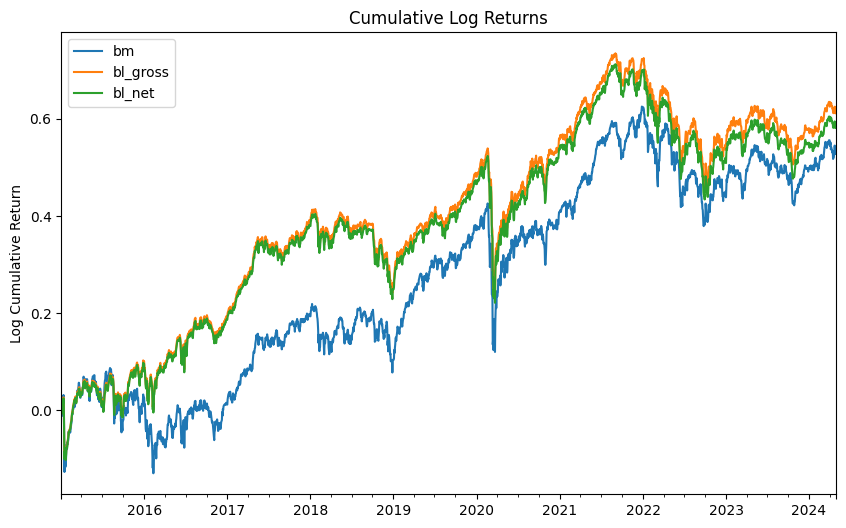

In [24]:
import numpy as np
import matplotlib.pyplot as plt

np.log(1 + sim).cumsum().plot(figsize=(10, 6), title="Cumulative Log Returns")
plt.ylabel("Log Cumulative Return")

Rolling 3-Year Annualized Return

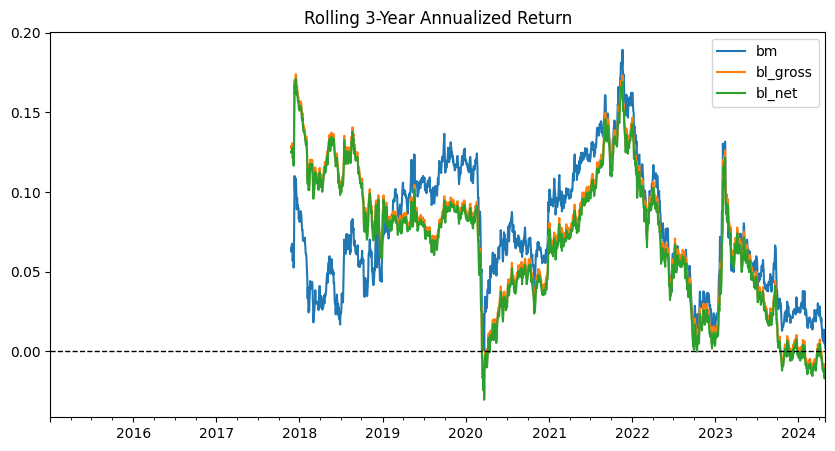

In [25]:
rolling_returns = sim.rolling(window=252*3).apply(lambda x: (1 + x).prod() ** (1/3) - 1)
rolling_returns.plot(figsize=(10, 5), title="Rolling 3-Year Annualized Return")
plt.axhline(0, color='black', linestyle='--', lw=1)


Rolling 1-Year Volatility

<Axes: title={'center': 'Rolling 1-Year Volatility'}>

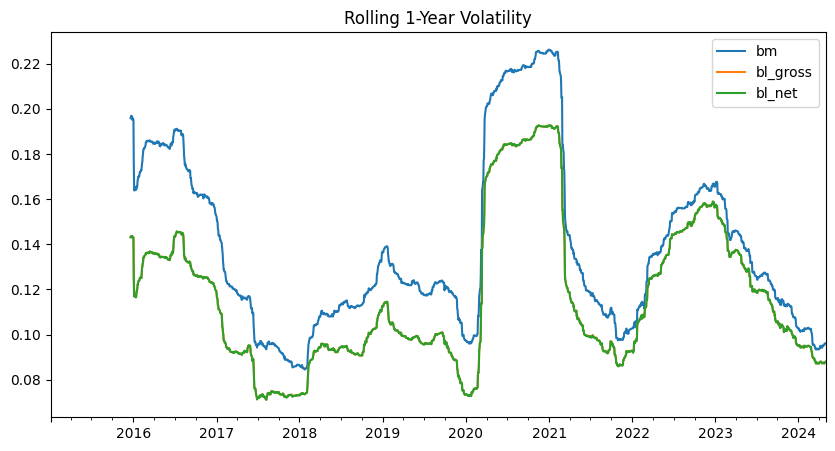

In [26]:
rolling_vol = sim.rolling(window=252).std() * np.sqrt(252)
rolling_vol.plot(figsize=(10, 5), title="Rolling 1-Year Volatility")


Rolling Sharpe Ratio (1Y)

<Axes: title={'center': 'Rolling 1-Year Sharpe Ratio'}>

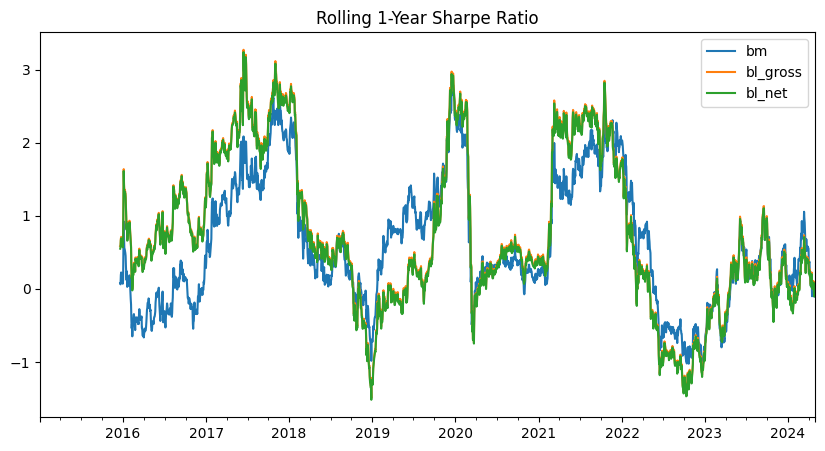

In [27]:
rolling_sharpe = sim.rolling(window=252).mean() / sim.rolling(window=252).std() * np.sqrt(252)
rolling_sharpe.plot(figsize=(10, 5), title="Rolling 1-Year Sharpe Ratio")


Drawdown Chart

<Axes: title={'center': 'Drawdown'}>

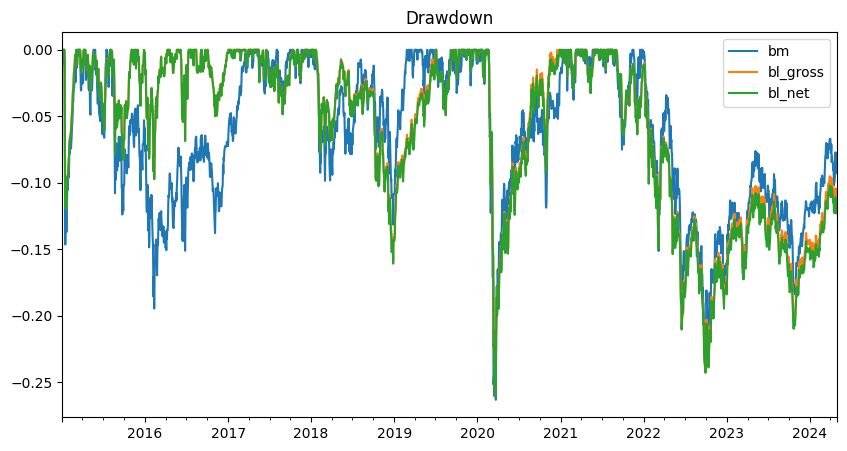

In [28]:
def compute_drawdown(series):
    return (series / series.cummax()) - 1

drawdowns = compute_drawdown((1 + sim).cumprod())
drawdowns.plot(title="Drawdown", figsize=(10, 5))


Turnover Plot

<Axes: title={'center': 'Portfolio Turnover'}>

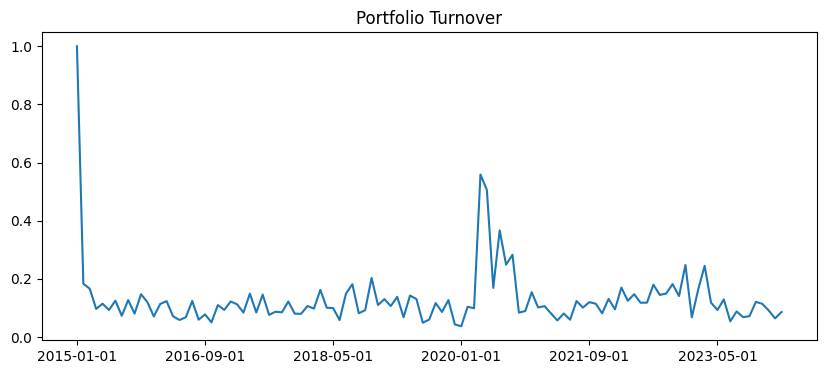

In [29]:
turnover_df = bt_bl_mom.strategy.turnover(return_series=bs.data.get_return_series())
turnover_df.plot(figsize=(10, 4), title='Portfolio Turnover')


Correlation with Benchmark

In [30]:
sim.corr()['bm']


bm          1.000000
bl_gross    0.917391
bl_net      0.917291
Name: bm, dtype: float64

Bull and Bear Market

In [31]:
spi = sim['bm'] 
spi_cum = (1 + spi).cumprod()
rolling_6m_return = spi_cum.pct_change(periods=126)  # ~6 months

market_regime = pd.Series(index=spi.index, dtype='str')
market_regime[rolling_6m_return > 0] = 'Bull'
market_regime[rolling_6m_return < 0] = 'Bear'


In [32]:
sim_with_regime = sim.copy()
sim_with_regime['Regime'] = market_regime

bull_returns = sim_with_regime[sim_with_regime['Regime'] == 'Bull'].drop(columns='Regime')
bear_returns = sim_with_regime[sim_with_regime['Regime'] == 'Bear'].drop(columns='Regime')


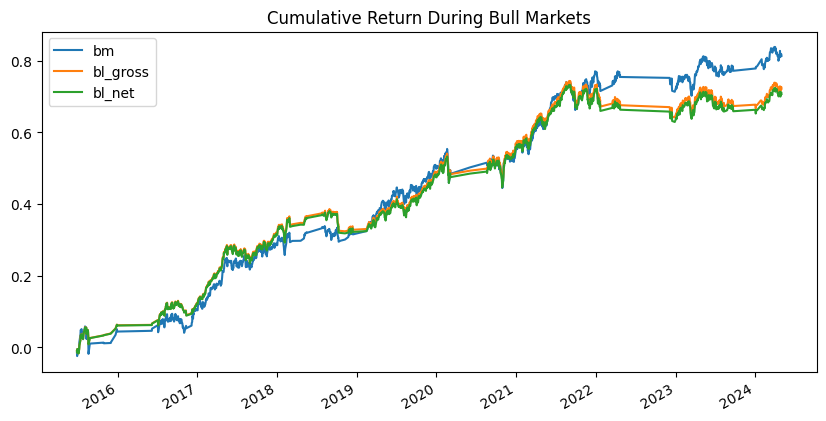

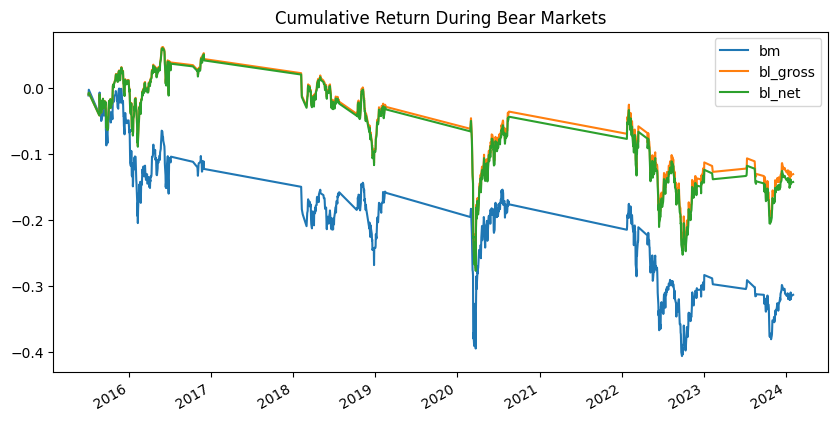

In [33]:
import matplotlib.pyplot as plt

cumulative_bull = np.log(1 + bull_returns).cumsum()
cumulative_bear = np.log(1 + bear_returns).cumsum()

cumulative_bull.plot(figsize=(10, 5), title="Cumulative Return During Bull Markets")
plt.show()

cumulative_bear.plot(figsize=(10, 5), title="Cumulative Return During Bear Markets")
plt.show()
